In [35]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/content/Data Penjualan Toko Buku.csv')
df.head()

,id_transaksi,jenis_item,jumlah,tanggal pembelian,nama_customer,total
0,133889.0,Alat Tulis,1,1/1/2010,Stacy Campos,120000.0
1,133889.0,Buku Sejarah,1,1/1/2010,Stacy Campos,150000.0
2,133889.0,Buku Anak-Anak,2,1/1/2010,Stacy Campos,400000.0
3,133889.0,Majalah Fashion,1,1/1/2010,Stacy Campos,130000.0
4,133889.0,Majalah Berita,2,1/1/2010,Stacy Campos,600000.0


In [7]:
df.isna().sum()

,0
id_transaksi,771
jenis_item,771
jumlah,0
tanggal pembelian,3
nama_customer,771
total,2


In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

,0
id_transaksi,0
jenis_item,0
jumlah,0
tanggal pembelian,0
nama_customer,0
total,0


In [5]:
df.duplicated().sum()

np.int64(673)

In [12]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df['id_transaksi'] = df['id_transaksi'].astype(int)
df['tanggal pembelian'] = pd.to_datetime(df['tanggal pembelian'], errors='coerce')
df.dropna(subset=['tanggal pembelian'], inplace=True)

In [16]:
snapshot_date = df['tanggal pembelian'].max() + pd.Timedelta(days=1)
rfm_df = df.groupby('nama_customer').agg(
    Recency=('tanggal pembelian', lambda x: (snapshot_date - x.max()).days),
    Frequency=('id_transaksi', 'nunique'),
    Monetary=('total', 'sum')
).reset_index()

In [17]:
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)

In [18]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [19]:
K = 4
kmeans_final = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [28]:
rfm_df['Cluster'] = kmeans_final.labels_
cluster_analysis = rfm_df.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Count=('nama_customer', 'count')
).reset_index()

cluster_analysis[['Avg_Monetary']] = cluster_analysis[['Avg_Monetary']].round(0)
cluster_analysis[['Avg_Recency', 'Avg_Frequency']] = cluster_analysis[['Avg_Recency', 'Avg_Frequency']].round(1)

print("\nAnalisis Kluster Akhir (K=4)")
print(cluster_analysis.round(1).to_markdown(index=False, numalign='left', stralign='left'))


Analisis Kluster Akhir (K=4)
| Cluster   | Avg_Recency   | Avg_Frequency   | Avg_Monetary   | Count   |
|:----------|:--------------|:----------------|:---------------|:--------|
| 0         | 2026          | 1               | 1.69338e+07    | 248     |
| 1         | 1.2           | 1               | 1.35849e+07    | 80      |
| 2         | 1965.9        | 1               | 4.45013e+06    | 76      |
| 3         | 1283          | 2               | 3.406e+07      | 1       |


In [23]:
output_dir = 'deployment_assets'
os.makedirs(output_dir, exist_ok=True)

In [26]:
model_filename = os.path.join(output_dir, 'kmeans_model.pkl')
with open(model_filename, 'wb') as file:
    pickle.dump(kmeans_final, file)
    print(f"Model K-Means berhasil disimpan di: {model_filename}")

Model K-Means berhasil disimpan di: deployment_assets/kmeans_model.pkl


In [27]:
scaler_filename = os.path.join(output_dir, 'rfm_scaler.pkl')
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
    print(f"StandardScaler berhasil disimpan di: {model_filename}")

StandardScaler berhasil disimpan di: deployment_assets/kmeans_model.pkl


In [29]:
cluster_melt = pd.melt(
    cluster_analysis,
    id_vars='Cluster',
    value_vars=['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary'],
    var_name='RFM_Metric',
    value_name='Average_Value'
)

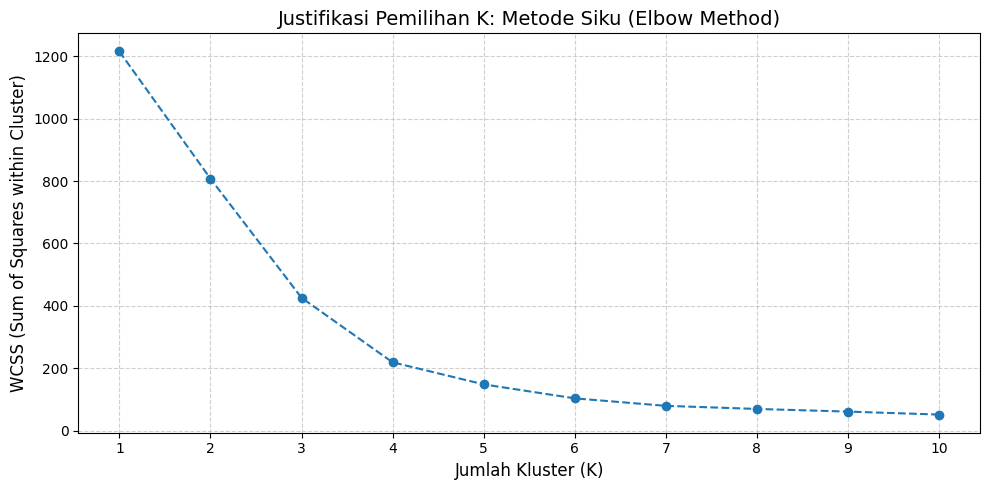

In [32]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Justifikasi Pemilihan K: Metode Siku (Elbow Method)', fontsize=14)
plt.xlabel('Jumlah Kluster (K)', fontsize=12)
plt.ylabel('WCSS (Sum of Squares within Cluster)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

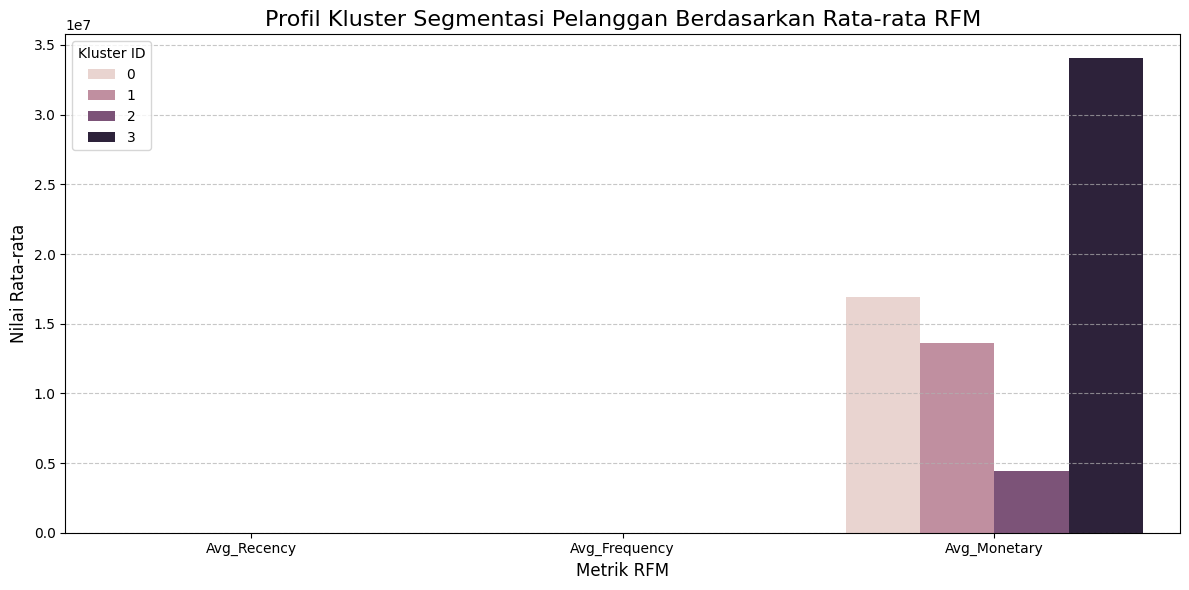

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(x='RFM_Metric', y='Average_Value', hue='Cluster', data=cluster_melt)
plt.title('Profil Kluster Segmentasi Pelanggan Berdasarkan Rata-rata RFM', fontsize=16)
plt.xlabel('Metrik RFM', fontsize=12)
plt.ylabel('Nilai Rata-rata', fontsize=12)
plt.legend(title='Kluster ID')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()